In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import os
import json
import PIL.Image
import numpy as np
import copy

In [7]:
!unzip -q lego_city.zip

In [88]:
class LegoCityDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, crop_percent=0.6):
        self.directory = directory
        self.crop_percent = crop_percent
        labels = []
        for filename in glob.glob(os.path.join(directory, 'labels/*.json')):
            with open(filename, 'r') as f:
                labels.append(json.load(f))
        self.labels = labels
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = copy.copy(self.labels[idx])
        
        image = PIL.Image.open(os.path.join(self.directory, 'images', label['image']))
        
        # resize to 224x224
        # crop bottom 60%
        
        image = transforms.functional.resized_crop(image, self.crop_percent * 224, 0, 224 - self.crop_percent * 224, 224, (224, 224))
        
        if np.random.rand(1) > 0.5:
            image = transforms.functional.hflip(image)
            label['left_steering'] = - label['left_steering']
            label['forward_steering'] = - label['forward_steering']
            label['right_steering'] = - label['right_steering']
        
        # random affine
        image = transforms.functional.to_grayscale(image, num_output_channels=3)
        image = transforms.functional.to_tensor(image)
        image = self.normalize(image)
        
        return image, torch.Tensor([label['left_steering'], label['forward_steering'], label['right_steering']])

In [102]:
dataset = LegoCityDataset('dataset', crop_percent=0.5)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 25, 25])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

In [103]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 3)
#model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 3)
device = torch.device('cuda')
model = model.to(device)

In [105]:
NUM_EPOCHS = 30
BEST_MODEL_PATH = 'best_model.pth'
best_accuracy = 0.0

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    
    train_loss = 0.0
    
    model.train()
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
    train_loss /= len(train_loader)
    
    test_loss = 0.0
    model.eval()
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
        
    print(train_loss, test_loss)

0.014338429424573074 0.03351282768184319
0.011594019343399188 0.04141230369452387
0.013248569755391642 0.03877412835136056
0.017366820882836528 0.04934852493694052
0.016571005509996958 0.03761587545275688
0.029220673234455964 0.043293687170371416
0.018510867778042502 0.05846266824752092
0.037662188056856394 0.07834313809871674
0.020376719724894923 0.03302238630130887
0.022858150345696646 0.050091953035444024
0.04134614092551849 0.04201730768196285
0.027719827157191256 0.049308134457096454
0.025599009442058476 0.031372819617390635
0.025678654582324354 0.05041633434593677
0.040056763851845804 0.04506804709322751
0.0176747009285133 0.07083099549636244
0.020723136438226156 0.029026450077071785
0.011388073760000143 0.047219014214351776
0.0099365738728507 0.04598717583343387
0.019499730699780313 0.04810361919924617
0.011793600564653223 0.04068486941047013
0.016660535729236224 0.039112007645890116
0.01818053030662916 0.06941990561783314
0.03128516644408757 0.05535761350765824
0.03561799731952

In [106]:
torch.save(model.state_dict(), 'lego_city_model.pth')

tensor([0.2090, 0.2303, 0.2363])
tensor([[0.2932, 0.4303, 0.3876]], device='cuda:0', grad_fn=<ThAddmmBackward>)


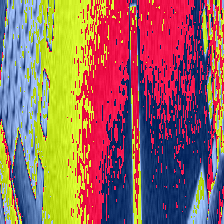

In [98]:
image, label = test_dataset[15]

model.eval()
print(label)
print(model(image[None,...].to(device)))
transforms.functional.to_pil_image(image)